In [ ]:
import os
from IPython.display import display

import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import ReduceLROnPlateau
from keras.models import load_model
from keras.preprocessing import image
from google.colab import drive
from ipywidgets import IntProgress


In [ ]:
drive.mount('drive')

Mounted at drive


## **Load and Split Dataset into training and validation**

In [ ]:
data_dir = os.path.join(os.getcwd(), 'drive', 'My Drive', 'parking_detection', 'parking_dataset_augmented')
img_width, img_height = (224, 224)
batch_size=16

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=42,
  image_size=(img_height, img_width),
  batch_size=batch_size
)

validation_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=42,
  image_size=(img_height, img_width),
  batch_size=batch_size
)

testing_ds = tf.keras.preprocessing.image_dataset_from_directory(
    os.path.join(os.getcwd(), 'drive', 'My Drive', 'parking_detection', 'test_data', 'testing_data'),
    seed=42,
    image_size=(img_height, img_width),
    batch_size=9
)

Found 3919 files belonging to 2 classes.
Using 3136 files for training.
Found 3919 files belonging to 2 classes.
Using 783 files for validation.
Found 16 files belonging to 2 classes.


# **Display sample of training set from dataset**

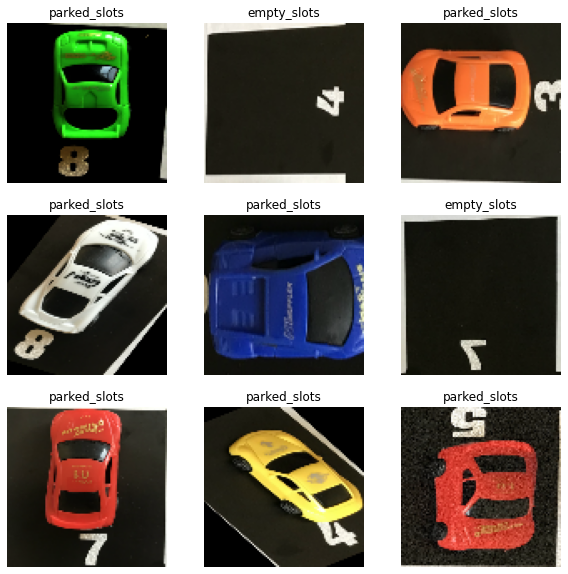

In [ ]:
plt.figure(figsize=(10, 10))

for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(train_ds.class_names[labels[i]])
    plt.axis("off")

# **Define Sequential Model**

In [ ]:
model = Sequential()
model.add(
    MobileNet(
        include_top=False,input_tensor=None, input_shape=(224, 224, 3), pooling='avg', classes=2, weights='imagenet'
        )
    )
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))

model.layers[0].trainable = False

model.compile(
    optimizer=SGD(lr=0.001),loss='binary_crossentropy',metrics=['accuracy']
)
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenet_1.00_224 (Function (None, 1024)              3228864   
_________________________________________________________________
dense_3 (Dense)              (None, 256)               262400    
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 128)               32896     
_________________________________________________________________
dropout_3 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 129       
Total params: 3,524,289
Trainable params: 295,425
Non-trainable params: 3,228,864
______________________________________

# **Fit Data to model and save model**


In [ ]:
model.fit(
  train_ds,
  validation_data=validation_ds,
  epochs=4
)

model.save(os.path.join(os.getcwd(), 'drive', 'My Drive', 'parking_detection', 'models', 'parking_detection_mobilenet.h5'))

Epoch 1/4
196/196 [==============================] - 170s 868ms/step - loss: 0.6204 - accuracy: 0.6881 - val_loss: 0.2605 - val_accuracy: 0.9349
Epoch 2/4
196/196 [==============================] - 170s 867ms/step - loss: 0.3148 - accuracy: 0.8721 - val_loss: 0.1429 - val_accuracy: 0.9796
Epoch 3/4
196/196 [==============================] - 173s 881ms/step - loss: 0.2114 - accuracy: 0.9295 - val_loss: 0.0939 - val_accuracy: 0.9911
Epoch 4/4
196/196 [==============================] - 173s 882ms/step - loss: 0.1606 - accuracy: 0.9509 - val_loss: 0.0648 - val_accuracy: 0.9936


# **Load saved model**

In [ ]:
model = load_model(os.path.join(os.getcwd(), 'drive', 'My Drive', 'parking_detection', 'models', 'parking_detection_mobilenet.h5'))

# **Evaluate model accuracy with validation data**

In [ ]:
model.evaluate(validation_ds)

48/48 [==============================] - 310s 6s/step - loss: 0.6820 - accuracy: 0.9961


[0.6820036172866821, 0.9960681796073914]

# **Evaluate model accuracy with testing data**

In [ ]:
model.evaluate(testing_ds)

2/2 [==============================] - 0s 144ms/step - loss: 0.0173 - accuracy: 1.0000


[0.017255529761314392, 1.0]

# **Visualize model prediction with testing data**

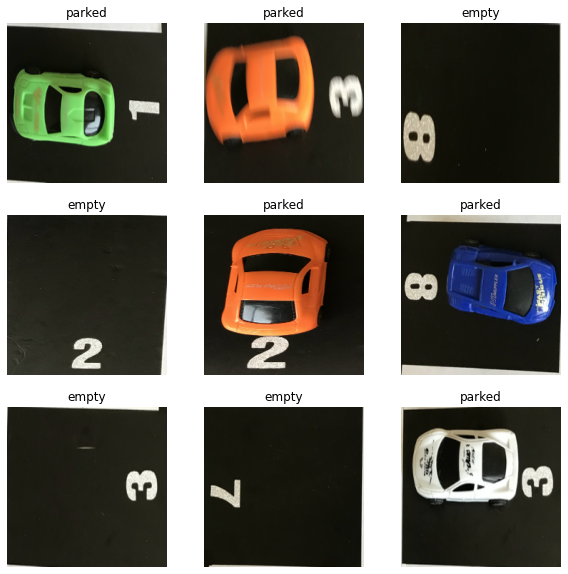

In [ ]:
plt.figure(figsize=(10, 10))

for images, labels in testing_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    im = images[i]
    im = np.expand_dims(im, axis=0)
    im = im.reshape(1, 224, 224, 3)
    plt.title(['empty', 'parked'][int(round(model.predict(im)[0][0]))])
    plt.axis("off")

# **Convert to 8 BIT quantized tflite model**

In [ ]:
IMAGE_SIZE = 224

def representative_data_gen():
    dataset_list = tf.data.Dataset.list_files(
        data_dir + '/*/*'
    )
    for i in range(100):
        image = next(iter(dataset_list))
        image = tf.io.read_file(image)
        image = tf.io.decode_png(image, channels=3)
        image = tf.image.resize(image, [IMAGE_SIZE, IMAGE_SIZE])
        # image = tf.cast(image / 255., tf.float32)
        image = tf.expand_dims(image, 0)
        yield [image]


converter = tf.lite.TFLiteConverter.from_keras_model(
    model
)
converter.optimizations = [tf.lite.Optimize.DEFAULT]

converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]

converter.inference_input_type = tf.uint8
converter.inference_output_type = tf.uint8

converter.representative_dataset = representative_data_gen
tflite_model = converter.convert()

with open(os.path.join(os.getcwd(), 'drive', 'My Drive', 'parking_detection', 'models', 'parking_detection_mobilenet_quant.tflite'), 'wb') as f:
  f.write(tflite_model)

INFO:tensorflow:Assets written to: /tmp/tmpq2mr15rp/assets


INFO:tensorflow:Assets written to: /tmp/tmpq2mr15rp/assets


# **Evaluate model accuracy after model quantization**

In [ ]:
for images, labels in validation_ds.take(1):  # only take first element of dataset
    batch_images = images.numpy()
    batch_labels = labels.numpy()

In [ ]:
def input_size(interpreter):
    """Returns input image size as (width, height) tuple."""
    _, height, width, _ = interpreter.get_input_details()[0]['shape']
    return width, height


def input_tensor(interpreter):
    """Returns input tensor view as numpy array of shape (height, width, 3)."""
    tensor_index = interpreter.get_input_details()[0]['index']
    return interpreter.tensor(tensor_index)()[0]


def output_tensor(interpreter):
    """Returns dequantized output tensor."""
    output_details = interpreter.get_output_details()[0]
    output_data = np.squeeze(interpreter.tensor(output_details['index'])())
    scale, zero_point = output_details['quantization']
    return scale * (output_data - zero_point)


def set_input(interpreter, data):
    """Copies data to input tensor."""
    input_tensor(interpreter)[:, :] = data


def get_output(interpreter, top_k=1, score_threshold=0.0):
    """Returns no more than top_k classes with score >= score_threshold."""
    score = output_tensor(interpreter)
    score = round(score)
    return [score]


In [ ]:
def classify_image(interpreter, input):
  set_input(interpreter, input)

  interpreter.invoke()

  classes = get_output(interpreter)

  return classes[0]

interpreter = tf.lite.Interpreter(os.path.join(os.getcwd(), 'drive', 'My Drive', 'parking_detection', 'models', 'parking_detection_mobilenet_quant.tflite'))
interpreter.allocate_tensors()

In [ ]:
input_size(interpreter)

(224, 224)

In [ ]:
batch_count = 1 or len(validation_ds) # Change value before or to 0 to test will all images
batchProgress = IntProgress(min=0, max=batch_count)
display(batchProgress)

prediction_values = []
# val_images = np.array(np.ones(shape=(224, 224, 3)))
truth_labels = np.array([])

print(f'Running accuracy test with {batch_count} batches of size {batch_size} images')
for i in range(1, batch_count+1):
  for images, labels in validation_ds.take(i):
    val_images = images.numpy()
    truth_labels = np.append(truth_labels, labels.numpy())

    for image in val_images:
      prediction = classify_image(interpreter, image)
      prediction_values.append(prediction)
  batchProgress.value += 1

tflite_accuracy = tf.keras.metrics.Accuracy()
tflite_accuracy(prediction_values, truth_labels)
print("Quant TF Lite accuracy: {:.3%}".format(tflite_accuracy.result()))

IntProgress(value=0, max=1)

Running accuracy test with 1 batches of size 16 images
Quant TF Lite accuracy: 100.000%


# **Visualize quantized model predictions**

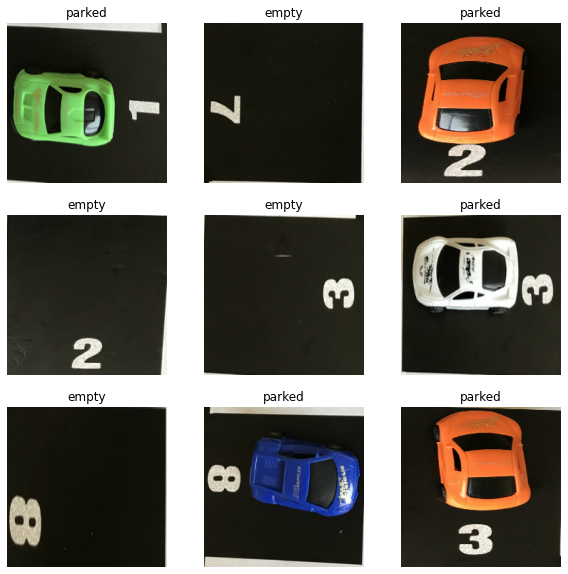

In [ ]:
plt.figure(figsize=(10, 10))

for images, labels in testing_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(['empty', 'parked'][int(classify_image(interpreter, images[i].numpy().reshape(1, 224, 224, 3)))])
    plt.axis("off")